In [22]:
import os
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import uncertainty_toolbox as uct
from tqdm import tqdm
import seaborn as sns

In [51]:
exp_dir_path = "/mnt/SSD2/nils/uq-method-box/experiments/experiments/uci_DeterministicGaussianModel_05-26-2023_19-11-38"
seed_dirs = glob.glob(os.path.join(exp_dir_path, "seed_*"), recursive=True)
seed_dirs


['/mnt/SSD2/nils/uq-method-box/experiments/experiments/uci_DeterministicGaussianModel_05-26-2023_19-11-38/seed_0',
 '/mnt/SSD2/nils/uq-method-box/experiments/experiments/uci_DeterministicGaussianModel_05-26-2023_19-11-38/seed_4',
 '/mnt/SSD2/nils/uq-method-box/experiments/experiments/uci_DeterministicGaussianModel_05-26-2023_19-11-38/seed_6',
 '/mnt/SSD2/nils/uq-method-box/experiments/experiments/uci_DeterministicGaussianModel_05-26-2023_19-11-38/seed_8',
 '/mnt/SSD2/nils/uq-method-box/experiments/experiments/uci_DeterministicGaussianModel_05-26-2023_19-11-38/seed_1',
 '/mnt/SSD2/nils/uq-method-box/experiments/experiments/uci_DeterministicGaussianModel_05-26-2023_19-11-38/seed_7',
 '/mnt/SSD2/nils/uq-method-box/experiments/experiments/uci_DeterministicGaussianModel_05-26-2023_19-11-38/seed_2',
 '/mnt/SSD2/nils/uq-method-box/experiments/experiments/uci_DeterministicGaussianModel_05-26-2023_19-11-38/seed_9',
 '/mnt/SSD2/nils/uq-method-box/experiments/experiments/uci_DeterministicGaussian

# Full training runs Dataframe

Holds information about the training itself

In [52]:
full_train_df = pd.DataFrame()
for dir in seed_dirs:
    df = pd.read_csv(os.path.join(dir, "model_0", "csv_logs", "version_0", "metrics.csv"))
    df["seed"] = dir.split("_")[-1]
    full_train_df = pd.concat([full_train_df, df], ignore_index=True)
full_train_df = full_train_df.sort_values(by="seed")

# Inspect Training Results

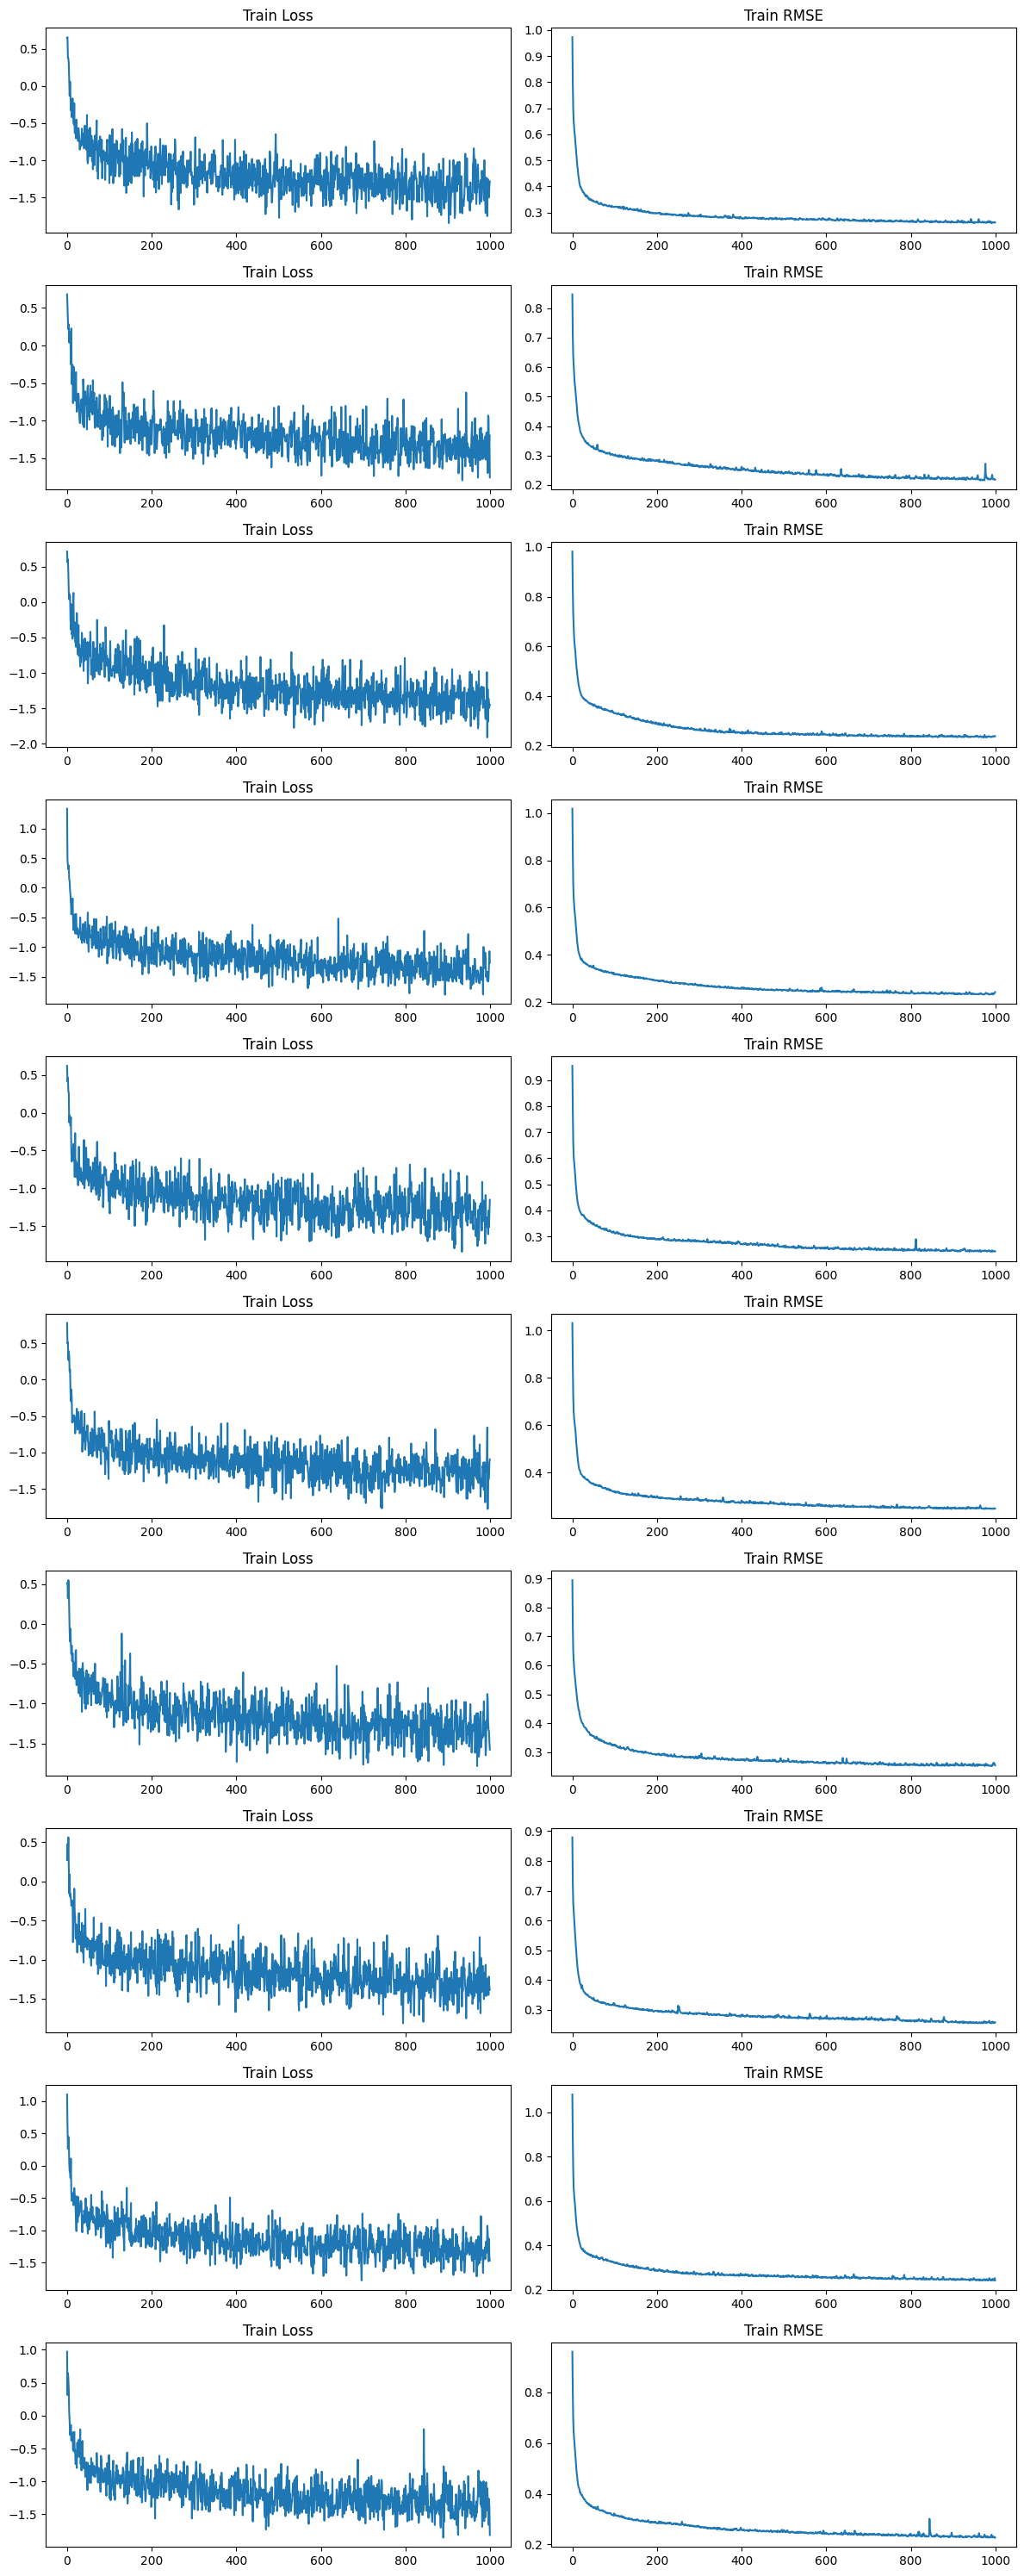

In [53]:
fig, axs = plt.subplots(nrows=len(seed_dirs), ncols=2, figsize=(12, 3*len(seed_dirs)))
for idx in range(len(seed_dirs)):
    run_df = full_train_df[full_train_df["seed"] == str(idx)]
    train_loss = run_df[run_df["train_loss"].notna()]["train_loss"]
    train_rmse = run_df[run_df["train_RMSE"].notna()]["train_RMSE"]
    axs[idx, 0].plot(np.arange(len(train_loss)), train_loss)
    axs[idx, 0].set_title("Train Loss")
    axs[idx, 1].plot(np.arange(len(train_rmse)), train_rmse)
    axs[idx, 1].set_title("Train RMSE")
plt.tight_layout()

# Predictions DataFrame

In [54]:
full_metric_df = pd.DataFrame()
full_metric_df_unnorm = pd.DataFrame()
uq_metric_categories = ["scoring_rule", "avg_calibration", "sharpness", "accuracy"]
for dir in tqdm(seed_dirs):
    pred_df = pd.read_csv(os.path.join(dir, "prediction", "predictions.csv"))
    # normalized
    uq_metrics = uct.metrics.get_all_metrics(
            pred_df["mean"].values.squeeze(),
            pred_df["pred_uct"].values.squeeze(),
            pred_df["targets"].values.squeeze(),
            verbose=False,
        )
    metrics_dict = {uq_cat: uq_metrics[uq_cat] for uq_cat in uq_metric_categories}  
    metric_df = pd.DataFrame.from_dict(metrics_dict, orient="index").stack().to_frame().T
    metric_df.columns = metric_df.columns.droplevel(0)
    metric_df["seed"] = dir.split("_")[-1]
    full_metric_df = pd.concat([full_metric_df, metric_df], ignore_index=True)

    # unnormalized
    # normalized
    uq_metrics = uct.metrics.get_all_metrics(
            pred_df["unnorm_mean"].values.squeeze(),
            pred_df["unnorm_std"].values.squeeze(),
            pred_df["unnorm_targets"].values.squeeze(),
            verbose=False,
        )
    metrics_dict = {uq_cat: uq_metrics[uq_cat] for uq_cat in uq_metric_categories}  
    metric_df = pd.DataFrame.from_dict(metrics_dict, orient="index").stack().to_frame().T
    metric_df.columns = metric_df.columns.droplevel(0)
    metric_df["seed"] = dir.split("_")[-1]
    full_metric_df_unnorm = pd.concat([full_metric_df_unnorm, metric_df], ignore_index=True)


# long format df for sns
full_metric_long_df = full_metric_df.melt(id_vars="seed")
full_metric_long_df.columns = ["seed", "uq_metric", "value"]

full_metric_unnorm_long_df = full_metric_df_unnorm.melt(id_vars="seed")
full_metric_unnorm_long_df.columns = ["seed", "uq_metric", "value"]

full_metric_df

100%|██████████| 10/10 [00:29<00:00,  2.91s/it]


,nll,crps,check,interval,rms_cal,ma_cal,miscal_area,sharp,mae,rmse,mdae,marpd,r2,corr,seed
0,10.989983,0.185694,0.093598,1.118909,0.119888,0.107864,0.108954,0.347766,0.245309,0.348044,0.168127,53.435858,0.876178,0.937224,0
1,0.608088,0.171173,0.086370,0.944293,0.130285,0.123398,0.124645,0.326111,0.239470,0.330848,0.171409,51.450930,0.902567,0.950217,4
2,1.281715,0.138215,0.069716,0.786535,0.069987,0.060097,0.060616,0.227468,0.181988,0.264647,0.106249,41.755370,0.933576,0.969376,6
3,0.890305,0.159369,0.080401,0.877007,0.133318,0.121761,0.122938,0.240117,0.223052,0.291369,0.197402,51.758497,0.916866,0.960959,8
4,0.833532,0.149535,0.075468,0.791835,0.088635,0.075368,0.076059,0.236691,0.204988,0.271623,0.162342,54.726796,0.910607,0.955354,1
5,0.118949,0.155452,0.078483,0.767453,0.115575,0.097369,0.098289,0.300153,0.219470,0.293925,0.154500,45.339835,0.914802,0.957252,7
6,0.628720,0.138797,0.070038,0.752915,0.118193,0.105684,0.106660,0.215157,0.190826,0.254691,0.159101,49.194488,0.918087,0.958652,2
7,0.228363,0.140770,0.071073,0.724931,0.114354,0.102913,0.103952,0.195103,0.193207,0.267782,0.125409,48.374125,0.913772,0.956084,9
8,12.374964,0.171693,0.086549,1.020704,0.127610,0.112039,0.113171,0.245121,0.230220,0.349761,0.160109,57.084875,0.852076,0.924801,5
9,0.493378,0.172979,0.087312,0.922414,0.118311,0.099612,0.100618,0.324836,0.235513,0.327477,0.168722,57.116683,0.902569,0.952036,3


# Test Metrics Results

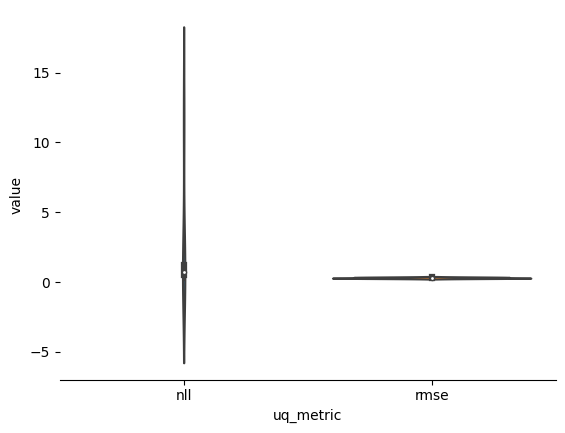

In [55]:
# select metrics you want to see violin plot for
violin_metrics = ["nll", "rmse"]
sns.violinplot(data=full_metric_long_df[full_metric_long_df["uq_metric"].isin(violin_metrics)], x="uq_metric", y="value")
sns.despine(left=True)

Text(0.5, 0, 'Seed')

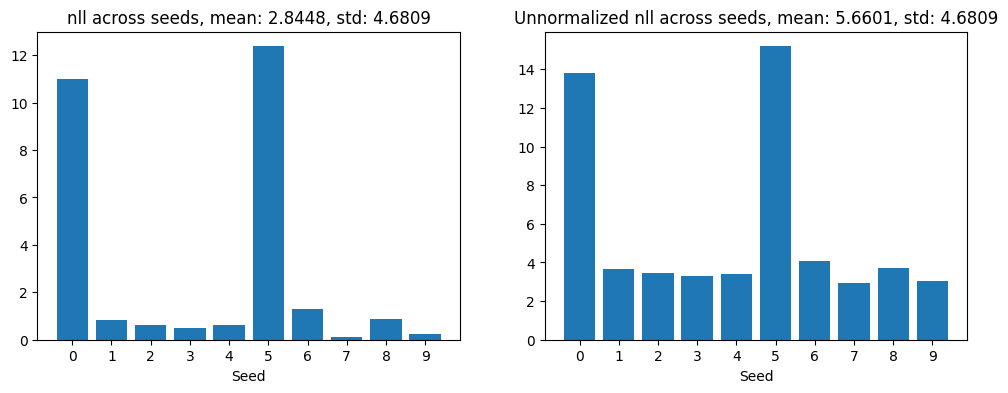

In [56]:
# select one of the available metrics in `full_metric_df`
metric = "nll"
single_metric_df = full_metric_long_df[full_metric_long_df["uq_metric"]==metric].sort_values(by="seed")
single_metric_unnorm_df = full_metric_unnorm_long_df[full_metric_unnorm_long_df["uq_metric"]==metric].sort_values(by="seed")
fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
ax[0].bar(single_metric_df["seed"], single_metric_df["value"])
ax[0].set_title(f"{metric} across seeds, mean: {single_metric_df['value'].mean():.4f}, std: {single_metric_df['value'].std():.4f}")
ax[0].set_xlabel("Seed")

ax[1].bar(single_metric_unnorm_df["seed"], single_metric_unnorm_df["value"])
ax[1].set_title(f"Unnormalized {metric} across seeds, mean: {single_metric_unnorm_df['value'].mean():.4f}, std: {single_metric_unnorm_df['value'].std():.4f}")
ax[1].set_xlabel("Seed")